
# Fit Multiple Data Sets Using Model Interface

Fitting multiple (simulated) Gaussian data sets simultaneously, using the
Model interface.

All minimizers require the residual array to be one-dimensional. Therefore,
in the ``objective`` function we need to ``flatten`` the array before
returning it.


In [1]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit import Parameters, minimize, report_fit
from lmfit.models import GaussianModel

Create N simulated Gaussian data sets



In [2]:
N = 5
np.random.seed(2021)
x = np.linspace(-1, 2, 151)
data = []
for _ in np.arange(N):
    params = Parameters()
    params.add('amplitude', value=0.60 + 9.50*np.random.rand())
    params.add('center', value=-0.20 + 1.20*np.random.rand())
    params.add('sigma', value=0.25 + 0.03*np.random.rand())
    dat = (GaussianModel().eval(x=x, params=params) +
           np.random.normal(size=x.size, scale=0.1))
    data.append(dat)
data = np.array(data)

The objective function will extract and evaluate a Gaussian from the
compound model



In [3]:
def objective(params, x, data, model):
    """Calculate total residual for fits of Gaussians to several data sets."""
    ndata, _ = data.shape
    resid = 0.0*data[:]

    # make residual per data set
    for i in range(ndata):
        components = model.components[i].eval(params=params, x=x)
        resid[i, :] = data[i, :] - components

    # now flatten this to a 1D array, as minimize() needs
    return resid.flatten()

Create a composite model by adding Gaussians



In [4]:
model_arr = [GaussianModel(prefix=f'n{i+1}_') for i, _ in enumerate(data)]
model = sum(model_arr[1:], start=model_arr[0])
model_arr, model

([Model(gaussian, prefix='n1_'),
  Model(gaussian, prefix='n2_'),
  Model(gaussian, prefix='n3_'),
  Model(gaussian, prefix='n4_'),
  Model(gaussian, prefix='n5_')],
 ((((Model(gaussian, prefix='n1_') + Model(gaussian, prefix='n2_')) + Model(gaussian, prefix='n3_')) + Model(gaussian, prefix='n4_')) + Model(gaussian, prefix='n5_')))

Prepare the fitting parameters and constrain n2_sigma, ..., nN_sigma to be
equal to n1_sigma



In [5]:
fit_params = model.make_params()
for iy, y in enumerate(data):
    fit_params.add(f'n{iy+1}_amplitude', value=0.5, min=0.0, max=200)
    fit_params.add(f'n{iy+1}_center', value=0.4, min=-2.0, max=2.0)
    fit_params.add(f'n{iy+1}_sigma', value=0.3, min=0.01, max=3.0)

    if iy > 0:
        fit_params[f'n{iy+1}_sigma'].expr = 'n1_sigma'

Run the global fit and show the fitting result



In [6]:
out = minimize(objective, fit_params, args=(x, data, model))
report_fit(out.params)

[[Variables]]
    n1_amplitude:  6.40552155 +/- 0.01575090 (0.25%) (init = 0.5)
    n1_center:     0.68032886 +/- 8.6209e-04 (0.13%) (init = 0.4)
    n1_sigma:      0.25743367 +/- 3.4131e-04 (0.13%) (init = 0.3)
    n2_amplitude:  6.98975626 +/- 0.01585971 (0.23%) (init = 0.5)
    n2_center:     0.50446887 +/- 7.9004e-04 (0.16%) (init = 0.4)
    n2_sigma:      0.25743367 +/- 3.4131e-04 (0.13%) == 'n1_sigma'
    n3_amplitude:  7.30195609 +/- 0.01592142 (0.22%) (init = 0.5)
    n3_center:    -0.08261146 +/- 7.5626e-04 (0.92%) (init = 0.4)
    n3_sigma:      0.25743367 +/- 3.4131e-04 (0.13%) == 'n1_sigma'
    n4_amplitude:  6.01461340 +/- 0.01568302 (0.26%) (init = 0.5)
    n4_center:     0.07382999 +/- 9.1812e-04 (1.24%) (init = 0.4)
    n4_sigma:      0.25743367 +/- 3.4131e-04 (0.13%) == 'n1_sigma'
    n5_amplitude:  9.07744386 +/- 0.01631785 (0.18%) (init = 0.5)
    n5_center:     0.34402084 +/- 6.0834e-04 (0.18%) (init = 0.4)
    n5_sigma:      0.25743367 +/- 3.4131e-04 (0.13%) == 'n1

Plot the data sets and fits



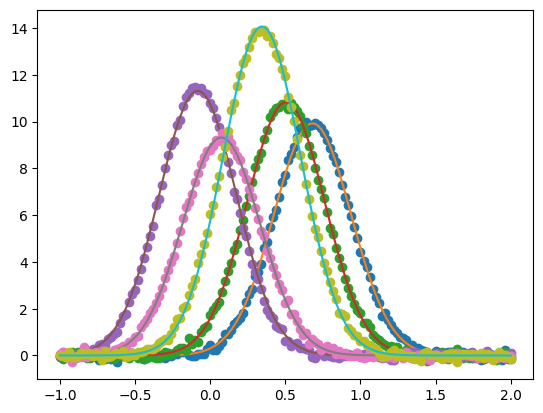

In [7]:
plt.figure()
for i, y in enumerate(data):
    components = model.eval_components(params=out.params, x=x)
    plt.plot(x, y, 'o', x, components[f'n{i+1}_'], '-')

plt.show()

[[Variables]]
    n1_g1_amplitude:  2.70034501 (init = 1)
    n1_g1_center:     0.66537442 (init = 0.2)
    n1_g1_sigma:      0.16853166 (init = 0.2)
    n1_g2_amplitude:  1.00000000 (init = 1)
    n1_g2_center:     0.20000000 (init = 0.2)
    n1_g2_sigma:      0.20000000 (init = 0.2)
    n1_c_c:           0.10000000 (init = 0.1)
    n1_g1_fwhm:       0.39686171 == '2.3548200*n1_g1_sigma'
    n1_g1_height:     6.39216321 == '0.3989423*n1_g1_amplitude/max(1e-15, n1_g1_sigma)'
    n1_g2_fwhm:       0.47096400 == '2.3548200*n1_g2_sigma'
    n1_g2_height:     1.99471150 == '0.3989423*n1_g2_amplitude/max(1e-15, n1_g2_sigma)'


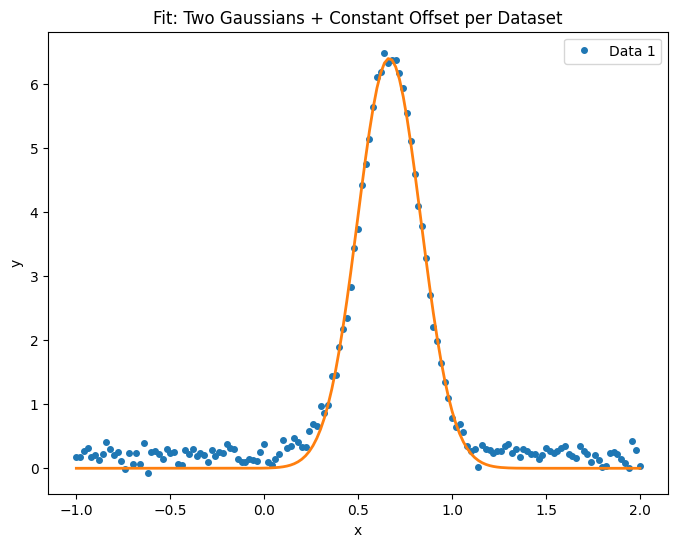

In [8]:
import matplotlib.pyplot as plt
import numpy as np

from lmfit import Parameters, minimize, report_fit
from lmfit.models import GaussianModel, ConstantModel

##############################################################################
# Create N simulated data sets each composed of 2 Gaussians + a constant
N = 1
np.random.seed(2021)
x = np.linspace(-1, 2, 151)
data = []

for _ in np.arange(N):
    # Random parameters for simulation
    A1, mu1, s1 = 0.5+8*np.random.rand(), -0.2 + 1.2*np.random.rand(), 0.15
    A2, mu2, s2 = 0.5+4*np.random.rand(), +0.2 + 1.2*np.random.rand(), 0.20
    C = 0.2*np.random.rand()

    g1 = A1 * np.exp(-(x-mu1)**2/(2*s1**2))
    g2 = A2 * np.exp(-(x-mu2)**2/(2*s2**2))

    dat = g1 + g2 + C + np.random.normal(size=x.size, scale=0.1)
    data.append(dat)

data = np.array(data)

##############################################################################
# Objective: sum of squared residuals for all datasets
def objective(params, x, data, model):
    ndata, _ = data.shape
    resid = 0.0 * data[:]

    # per-dataset residuals
    for i in range(ndata):
        components = model.components[i].eval(params=params, x=x)
        resid[i, :] = data[i, :] - components

    return resid.flatten()   # must be 1D

##############################################################################
# Build composite model: For each dataset -> (Gaussian + Gaussian + Constant)
model_arr = []
for i in range(N):
    g1 = GaussianModel(prefix=f'n{i+1}_g1_')
    g2 = GaussianModel(prefix=f'n{i+1}_g2_')
    c  = ConstantModel(prefix=f'n{i+1}_c_')

    model_arr.append(g1 + g2 + c)

# Combine into a single multi-dataset model
model = sum(model_arr[1:], start=model_arr[0])

##############################################################################
# Set initial parameters with bounds
fit_params = model.make_params()

for i in range(N):
    # First Gaussian
    fit_params[f'n{i+1}_g1_amplitude'].set(value=1, min=0)
    fit_params[f'n{i+1}_g1_center'].set(value=0.2, )
    fit_params[f'n{i+1}_g1_sigma'].set(value=0.2, )

    # Second Gaussian
    fit_params[f'n{i+1}_g2_amplitude'].set(value=1, min=0)
    fit_params[f'n{i+1}_g2_center'].set(value=0.2, )
    fit_params[f'n{i+1}_g2_sigma'].set(value=0.2, )

    # Constant background
    fit_params[f'n{i+1}_c_c'].set(value=0.1)

##############################################################################
# OPTIONAL: Constrain sigmas across datasets (example)
# for i in range(1, N):
#    fit_params[f'n{i+1}_g1_sigma'].expr = 'n1_g1_sigma'
#    fit_params[f'n{i+1}_g2_sigma'].expr = 'n1_g2_sigma'

##############################################################################
# Perform global fit
out = minimize(objective, fit_params, args=(x, data, model))
report_fit(out.params)

##############################################################################
# Plot results
plt.figure(figsize=(8, 6))
for i in range(N):
    # Evaluate full model for this dataset
    comp = model.components[i].eval(params=out.params, x=x)
    plt.plot(x, data[i], 'o', ms=4, label=f'Data {i+1}')
    plt.plot(x, comp, '-', lw=2)

plt.legend()
plt.xlabel('x')
plt.ylabel('y')
plt.title('Fit: Two Gaussians + Constant Offset per Dataset')
plt.show()